In [17]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import trange

In [2]:
! gdown https://avatars.githubusercontent.com/u/6183533?v=4 -O asharifiz.png

Downloading...
From: https://avatars.githubusercontent.com/u/6183533?v=4
To: /kaggle/working/asharifiz.png
100%|████████████████████████████████████████| 218k/218k [00:00<00:00, 7.81MB/s]


In [3]:
class Layer:
    def __init__(self):
        self.inp = None
        self.out = None

    def __call__(self, inp: np.ndarray) -> np.ndarray:
        return self.forward(inp)

    def forward(self, inp: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def step(self, lr: float) -> None:
        pass


class Linear(Layer):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.w = 0.1 * np.random.rand(in_dim, out_dim)
        self.b = np.zeros((1, out_dim))
        self.dw = np.zeros_like(self.w)
        self.db = np.zeros_like(self.b)

    def forward(self, inp: np.ndarray) -> np.ndarray:
        self.inp = inp
        self.out = np.dot(inp, self.w) + self.b
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        self.dw = np.dot(self.inp.T, up_grad)
        self.db = np.sum(up_grad, axis = 0)
        down_grad = np.dot(up_grad, self.w.T)
        return down_grad

    def step(self, lr: float) -> None:
        self.w -= lr * self.dw
        self.b -= lr * self.db


class ReLU(Layer):
    def forward(self, inp: np.ndarray) -> np.ndarray:
        self.inp = inp
        self.out = np.maximum(0, inp)
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        down_grad = up_grad * (self.inp > 0)
        return down_grad


class Softmax(Layer):
    def forward(self, inp: np.ndarray) -> np.ndarray:
        exp_values = np.exp(inp - np.max(inp, axis = 1, keepdims = True))
        self.out = exp_values / np.sum(exp_values, axis = 1, keepdims = True)
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        down_grad = np.empty_like(up_grad)
        for i in range(up_grad.shape[0]):
            single_output = self.out[i].reshape(-1, 1)
            jacobian = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            down_grad[i] = np.dot(jacobian, up_grad[i])
        return down_grad


class Loss:
    def __init__(self):
        self.prediction = None
        self.target = None
        self.loss = None

    def __call__(self, prediction: np.ndarray, target: np.ndarray) -> float:
        return self.forward(prediction, target)

    def forward(self, prediction: np.ndarray, target: np.ndarray) -> float:
        raise NotImplementedError

    def backward(self) -> np.ndarray:
        raise NotImplementedError


class CrossEntropy(Loss):
    def forward(self, prediction: np.ndarray, target: np.ndarray) -> float:
        self.prediction = prediction
        self.target = target
        clipped_pred = np.clip(prediction, 1e-12, 1.0)
        self.loss = -np.mean(np.sum(target * np.log(clipped_pred), axis = 1))
        return self.loss

    def backward(self) -> np.ndarray:
        grad = -self.target / self.prediction / self.target.shape[0]
        return grad


class CNN:
    def __init__(self, layers: list[Layer], loss_fn: Loss, lr: float) -> None:
        self.layers = layers
        self.loss_fn = loss_fn
        self.lr = lr

    def __call__(self, inp: np.ndarray) -> np.ndarray:
        return self.forward(inp)

    def forward(self, inp: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            inp = layer.forward(inp)
        return inp

    def loss(self, prediction: np.ndarray, target: np.ndarray) -> float:
        return self.loss_fn(prediction, target)

    def backward(self) -> None:
        up_grad = self.loss_fn.backward()
        for layer in reversed(self.layers):
            up_grad = layer.backward(up_grad)

    def update(self) -> None:
        for layer in self.layers:
            layer.step(self.lr)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, epochs: int, batch_size: int) -> np.ndarray:
        losses, accuracies = np.empty(epochs), np.empty(epochs)
        for epoch in (pbar := trange(epochs)):
            running_loss = 0.0
            correct = 0.0
            for i in range(0, len(x_train), batch_size):
                x_batch = x_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]


                prediction = self.forward(x_batch)


                running_loss += self.loss(prediction, y_batch) * batch_size


                correct += np.sum(np.argmax(prediction, axis = 1) == np.argmax(y_batch, axis = 1))


                self.backward()


                self.update()


            running_loss /= len(x_train)
            accuracy = 100 * correct / len(x_train)
            pbar.set_description(f'Loss: {running_loss:.3f} | Accuracy: {accuracy:.2f}%')
            losses[epoch] = running_loss
            accuracies[epoch] = accuracy
        return losses, accuracies

In [15]:
def plot_conv(convolutions=None, img_src='asharifiz.png', sequential=False):
    img = mpimg.imread(img_src)
    cols = len(convolutions) + 1 if convolutions is not None else 1
    fig, axes = plt.subplots(1, cols, figsize=(15, 15 * cols))


    axes[0].imshow(img)
    axes[0].axis('off')  
    axes[0].set_title('Original')

    for i, conv in enumerate(convolutions):
        x = np.transpose(img, (2, 0, 1))
        x = np.expand_dims(x, axis=(0))
        out = conv(x).squeeze()
        out = np.transpose(out, (1, 2, 0))
        axes[i + 1].imshow(out)
        axes[i + 1].axis('off')  # Hide the axis
        axes[i + 1].set_title(f'Filter {i + 1}')
        if sequential:
            img = out

    plt.show()

def plot_results(losses, accuracies):
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(losses) + 1), losses)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(accuracies) + 1), accuracies)
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names, kept_classes):
    dim = len(kept_classes)
    labels = [class_names[i] for i in kept_classes]

    conf_mat = confusion_matrix(y_true, y_pred)
    norm_conf_mat = conf_mat / np.sum(conf_mat, axis=1)

    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.xticks(range(dim), labels, rotation=45)
    plt.yticks(range(dim), labels)
    plt.colorbar()

    for i in range(dim):
        for j in range(dim):
            c = conf_mat[j, i]
            color = 'black' if c > 500 else 'white'
            ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
    plt.show()


def get_data(filter_classes):
    fashion_mnist = fetch_openml("Fashion-MNIST", parser='auto')
    x, y = fashion_mnist['data'], fashion_mnist['target'].astype(int)

    filtered_indices = np.isin(y, filter_classes)
    x, y = x[filtered_indices].to_numpy(), y[filtered_indices]

    x = ((x / 255.) - .5) * 2
    removed_class_count = 0
    for i in range(10):  
        if i in filter_classes and removed_class_count != 0:
            y[y == i] = i - removed_class_count
        elif i not in filter_classes:
            removed_class_count += 1

    return train_test_split(x, y, test_size=10_000)


def onehot_encoder(y, num_labels):
    one_hot = np.zeros(shape=(y.size, num_labels), dtype=int)
    one_hot[np.arange(y.size), y] = 1
    return one_hot

In [5]:
class SimpleConv2D(Layer):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size


        self.w = 0.1 * np.random.randn(out_channels, in_channels, kernel_size, kernel_size)
        self.b = np.zeros((out_channels, 1))

    def forward(self, inp: np.ndarray) -> np.ndarray:
        self.inp = inp
        batch_size, in_channels, heigth, width = inp.shape
        assert in_channels == self.in_channels, 'Input channels must match.'


        out_height = height - self.kernel_size + 1
        out_width = width = self.kernel_size + 1
        self.out = np.zeros((batch_size, self.out_channels, out_height, out_width))


        for i in range(out_height):
            for j in range(out_width):
                region = inp[:, :, i:i+self.kernel_size, j:j+self.kernel_size]
                self.out[:, :, i, j] = np.tensordot(region, self.w, axes=([1, 2, 3], [1, 2, 3])) + self.b.T

        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        batch_size, in_channels, height, width = self.inp.shape
        _, _, out_height, out_width = up_grad.shape


        self.dw = np.zeros_like(self.w)
        self.db = np.sum(up_grad, axis = (0, 2, 3), keepdims = True).reshape(self.out_channels, i)
        down_grad = np.zeros_like(self.inp)


        for i in range(out_height):
            for j in range(out_width):
                region = self.inp[:, :, i:i_self.kernel_size, j:j+self.kernel_size]
                self.dw += np.tensordot(up_grad[:, :, i, j], region, axes=([0], [0]))
                for n in range(batch_size):
                    down_grad[n, :, i:i+self.kernel_size, j:j+kernel_size] += np.tensordot(self.w, up_grad[n, :, i], axes = (0, 0))


        return down_grad

    def step(self, lr: float) -> None:
        self.w -= lr * self.dw
        self.b -= lr * self.db

In [6]:
class Conv2D(Layer):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, padding: int = 0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        
        self.w = 0.1 * np.random.randn(out_channels, in_channels, kernel_size, kernel_size)
        self.b = np.zeros((out_channels, 1))

    def forward(self, inp: np.ndarray) -> np.ndarray:
        self.inp = inp
        batch_size, in_channels, height, width = inp.shape

        
        self.padded_inp = np.pad(inp, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')

        
        out_height = (height + 2 * self.padding - self.kernel_size) // self.stride + 1
        out_width = (width + 2 * self.padding - self.kernel_size) // self.stride + 1
        self.out = np.zeros((batch_size, self.out_channels, out_height, out_width))

        
        for i in range(out_height):
            for j in range(out_width):
                region = self.padded_inp[:, :, i*self.stride:i*self.stride+self.kernel_size, j*self.stride:j*self.stride+self.kernel_size]
                self.out[:, :, i, j] = np.tensordot(region, self.w, axes=([1, 2, 3], [1, 2, 3])) + self.b.T

        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        batch_size, in_channels, height, width = self.inp.shape
        _, _, out_height, out_width = up_grad.shape

        
        self.dw = np.zeros_like(self.w)
        self.db = np.sum(up_grad, axis=(0, 2, 3), keepdims=True).reshape(self.out_channels, 1)
        down_grad = np.zeros_like(self.padded_inp)

        
        for i in range(out_height):
            for j in range(out_width):
                region = self.padded_inp[:, :, i*self.stride:i*self.stride+self.kernel_size, j*self.stride:j*self.stride+self.kernel_size]
                self.dw += np.tensordot(up_grad[:, :, i, j], region, axes=([0], [0])) 
                for n in range(batch_size):
                    down_grad[n, :, i*self.stride:i*self.stride+self.kernel_size, j*self.stride:j*self.stride+self.kernel_size] += np.tensordot(self.w, up_grad[n, :, i, j], axes=(0, 0))

        
        if self.padding > 0:
            down_grad = down_grad[:, :, self.padding:-self.padding, self.padding:-self.padding]

        return down_grad

    def step(self, lr: float) -> None:
        self.w -= lr * self.dw
        self.b -= lr * self.db

In [7]:
x = np.arange(9).reshape(1, 1, 3, 3)
print(x)

convolution = Conv2D(in_channels=1 , out_channels=1, kernel_size=2)
kernel = np.ones(shape=(1, 1, 2, 2))
convolution.w = kernel

print(convolution(x))

[[[[0 1 2]
   [3 4 5]
   [6 7 8]]]]
[[[[ 8. 12.]
   [20. 24.]]]]


In [8]:
class MaxPool2D(Layer):
    def __init__(self, pool_size: int = 2, stride: int = 2):
        super().__init__()
        self.pool_size = pool_size
        self.stride = stride

    def forward(self, inp: np.ndarray) -> np.ndarray:
        self.inp = inp
        batch_size, channels, height, width = inp.shape

        out_height = (height - self.pool_size) // self.stride + 1
        out_width = (width - self.pool_size) // self.stride + 1

        out = np.zeros((batch_size, channels, out_height, out_width))

        for i in range(out_height):
            for j in range(out_width):
                region = inp[:, :, i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size]
                out[:, :, i, j] = np.max(region, axis = (2, 3))

        self.out = out
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        batch_size, channels, height, width = self.inp.shape
        down_grad = np.zeros_like(self.inp)

        out_height, out_width = up_grad.shape[2], up_grad.shape[3]

        for i in range(out_height):
            for j in range(out_width):
                region = self.inp[:, :, i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size]
                max_mask = (region == np.max(region, axis=(2, 3), keepdims=True))
                down_grad[:, :, i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size] += max_mask * up_grad[:, :, i, j][:, :, None, None]

        return down_grad

In [9]:
x = np.arange(16).reshape(1, 1, 4, 4)
print(x)

maxpool = MaxPool2D()
print(maxpool(x))

[[[[ 0  1  2  3]
   [ 4  5  6  7]
   [ 8  9 10 11]
   [12 13 14 15]]]]
[[[[ 5.  7.]
   [13. 15.]]]]


In [10]:
class AvgPool2D(Layer):
    def __init__(self, pool_size: int = 2, stride: int = 2):
        super().__init__()
        self.pool_size = pool_size
        self.stride = stride

    def forward(self, inp: np.ndarray) -> np.ndarray:
        self.inp = inp
        batch_size, channels, height, width = inp.shape

        out_height = (height - self.pool_size) // self.stride + 1
        out_width = (width - self.pool_size) // self.stride + 1

        out = np.zeros((batch_size, channels, out_height, out_width))

        for i in range(out_height):
            for j in range(out_width):
                region = inp[:, :, i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size]
                out[:, :, i, j] = np.mean(region, axis=(2, 3))

        self.out = out
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        batch_size, channels, height, width = self.inp.shape
        down_grad = np.zeros_like(self.inp)

        out_height, out_width = up_grad.shape[2], up_grad.shape[3]

        for i in range(out_height):
            for j in range(out_width):
                region_grad = up_grad[:, :, i, j][:, :, None, None] / (self.pool_size * self.pool_size)
                down_grad[:, :, i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size] += region_grad

        return down_grad

In [11]:
x = np.arange(16).reshape(1, 1, 4, 4)
print(x)

avgpool = AvgPool2D()
print(avgpool(x))

[[[[ 0  1  2  3]
   [ 4  5  6  7]
   [ 8  9 10 11]
   [12 13 14 15]]]]
[[[[ 2.5  4.5]
   [10.5 12.5]]]]


In [12]:
class Flatten(Layer):
    def forward(self, inp: np.ndarray) -> np.ndarray:
        self.inp_shape = inp.shape
        return inp.reshape(self.inp_shape[0], -1)

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        return up_grad.reshape(self.inp_shape)

In [13]:
x = np.arange(9).reshape(1, 1, 3, 3)
print(x)

flatten = Flatten()
print(flatten(x))

[[[[0 1 2]
   [3 4 5]
   [6 7 8]]]]
[[0 1 2 3 4 5 6 7 8]]


In [14]:
# Black and White Kernel
black_and_white = Conv2D(in_channels=3 , out_channels=3, kernel_size=3)
black_and_white.w = np.ones(shape=(3, 3, 3, 3)) / 27


# Red Channel
red = Conv2D(in_channels=3, out_channels=3, kernel_size=1)
red.w = np.zeros_like(red.w)
red.w[0, 0, :, :] = np.array([1])


# Green Channel
green = Conv2D(in_channels=3, out_channels=3, kernel_size=1)
green.w = np.zeros_like(green.w)
green.w[1, 1, :] = np.array([1])


# Blue Channel
blue = Conv2D(in_channels=3, out_channels=3, kernel_size=1)
blue.w = np.zeros_like(blue.w)
blue.w[2, 2, :] = np.array([1])


# Gaussian Blur Kernel
gaussian3 = Conv2D(in_channels=3, out_channels=3, kernel_size=3)
for i in range(3):
    for j in range(3):
        if i == j:
            gaussian3.w[i, j, :, :] = np.array([[1, 2, 1],
                                                [2, 4, 2],
                                                [1, 2, 1]]) / 16
        else:
            gaussian3.w[i, j, :, :] = 0


# Gaussian Blur Kernel
gaussian5 = Conv2D(in_channels=3, out_channels=3, kernel_size=5)
for i in range(3):
    for j in range(3):
        if i == j:
            gaussian5.w[i, j, :, :] = np.array([[1, 4, 6, 4, 1],
                                                [4, 16, 24, 16, 4],
                                                [6, 24, 36, 24, 6],
                                                [4, 16, 24, 16, 4],
                                                [1, 4, 6, 4, 1]]) / 256
        else:
            gaussian5.w[i, j, :, :] = 0


# Sobel (Vertical)
sobel_v = Conv2D(in_channels=3, out_channels=3, kernel_size=3)
for i in range(3):
    for j in range(3):
        if i == j:
            sobel_v.w[i, j, :, :] = np.array([[1, 0, -1],
                                              [2, 0, -2],
                                              [1, 0, -1]])
        else:
            sobel_v.w[i, j, :, :] = 0

# Sobel (Horizontal)
sobel_h = Conv2D(in_channels=3, out_channels=3, kernel_size=3)
for i in range(3):
    for j in range(3):
        if i == j:
            sobel_h.w[i, j, :, :] = np.array([[1, 2, 1],
                                              [0, 0, 0],
                                              [-1, -2, -1]])
        else:
            sobel_h.w[i, j, :, :] = 0


# Max Pool
max_pool = MaxPool2D()

# Average Pool
avg_pool = AvgPool2D()

In [15]:
class_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
               3: 'Dress', 4: 'Coat', 5:  'Sandal', 6: 'Shirt',
               7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


kept_classes = [0, 1, 7]  # T-shirt/top, Trouser, Sneaker


x_train, x_test, y_train, y_test = get_data(kept_classes)


x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)


y_train = onehot_encoder(y_train, num_labels=len(kept_classes))

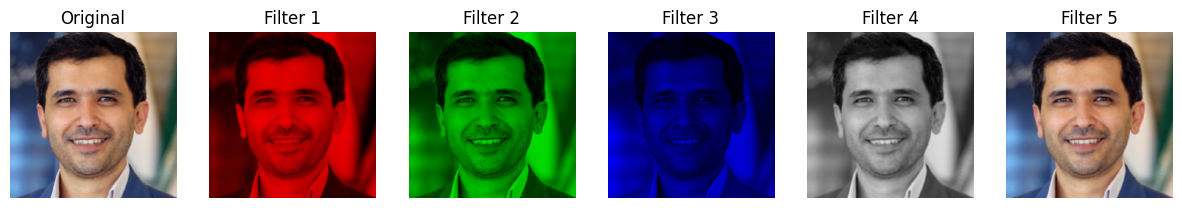

In [17]:
plot_conv(convolutions=[red, green, blue, black_and_white, avg_pool])

Loss: 0.069 | Accuracy: 97.73%: 100%|██████████| 30/30 [12:32<00:00, 25.08s/it]


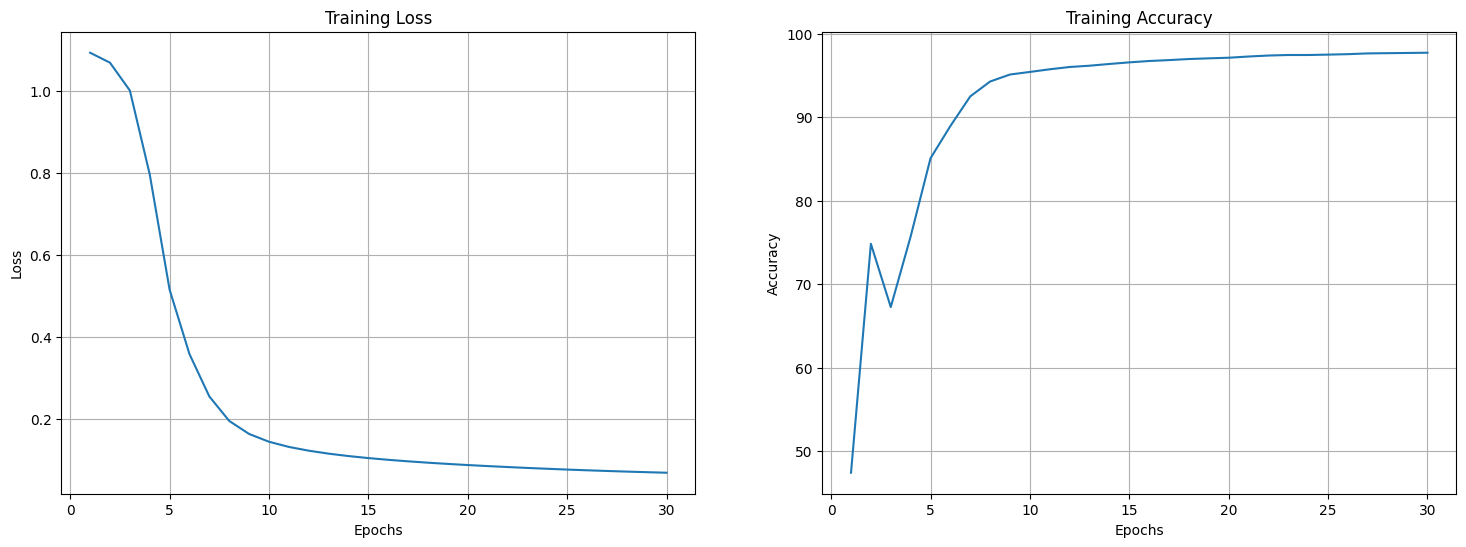

In [16]:
layers = [Conv2D(1, 4, 7, stride = 3),
          ReLU(),
          MaxPool2D(),
          Conv2D(4, 4, 3, padding = 1),
          ReLU(),
          MaxPool2D(),
          Flatten(),
          ReLU(),
          Linear(16, len(kept_classes)),
          Softmax()]

model = CNN(layers, CrossEntropy(), lr = 0.001)


results = model.train(x_train, y_train, epochs = 30, batch_size = 16)


plot_results(*results)

In [18]:
y_prediction = np.argmax(model(x_test), axis = 1)
acc = 100 * np.mean(y_prediction == y_test)
print(f'Test accuracy with {len(y_train)} training examples on {len(y_test)} test samples is {acc:.2f}%')

Test accuracy with 11000 training examples on 10000 test samples is 97.78%


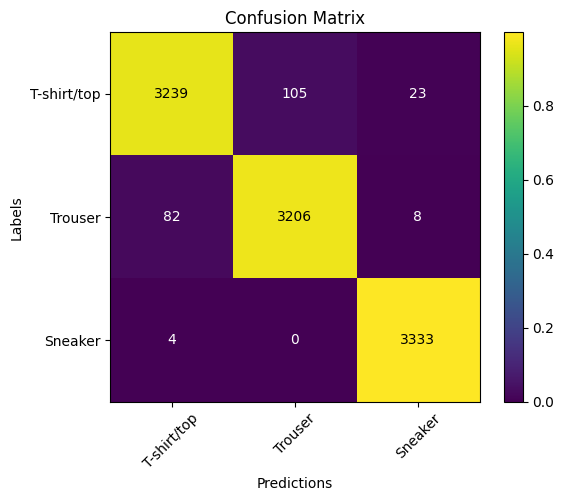

In [19]:
plot_confusion_matrix(y_test, y_prediction, class_names, kept_classes)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from tqdm import trange

In [4]:
def get_data(filter_classes):
    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

    # Function to filter dataset and remap labels
    def filter_and_remap(dataset, filter_classes):
        data = dataset.data.numpy()
        targets = dataset.targets.numpy()

        
        filtered_indices = np.isin(targets, filter_classes)
        data, targets = data[filtered_indices], targets[filtered_indices]

        
        data = ((data / 255.0) - 0.5) * 2

        
        removed_class_count = 0
        for i in range(10):
            if i in filter_classes and removed_class_count != 0:
                targets[targets == i] = i - removed_class_count
            elif i not in filter_classes:
                removed_class_count += 1

        
        dataset.data = torch.tensor(data, dtype=torch.float32)
        dataset.targets = torch.tensor(targets, dtype=torch.long)
        return dataset

    
    trainset = filter_and_remap(trainset, filter_classes)
    testset = filter_and_remap(testset, filter_classes)

    return trainset, testset


kept_classes = [0, 1, 7]  # T-shirt/top, Trouser, Sneaker
trainset, testset = get_data(kept_classes)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

In [13]:
def train_epoch(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss = 0.
    train_acc = 0.
    for images, labels in dataloader:
        images, labels = images, labels
        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (logits.argmax(dim=1) == labels).sum().item()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader.dataset)
    return train_loss, 100 * train_acc

def train_model(model, loader, optimizer, n_epochs):
    losses, accuracies = np.empty(n_epochs), np.empty(n_epochs)
    loss_fn = nn.CrossEntropyLoss()
    for i in (pbar := trange(n_epochs)):
        loss, acc = train_epoch(model, loader, loss_fn, optimizer)
        losses[i], accuracies[i] = loss, acc
        pbar.set_description(f'Loss: {loss:.3f} | Accuracy: {acc:.2f}% ')
    return losses, accuracies

def test_model(model, loader):
    model.eval()
    acc = 0.
    y_test, y_prediction =[], []
    with torch.no_grad():
        for images, labels in loader:
            logits = model(images)
            pred = logits.argmax(dim=1)
            acc += (pred == labels).sum().item()
            y_test.extend(labels.numpy())
            y_prediction.extend(pred.numpy())
    size = len(loader.dataset)
    acc = 100 * acc / size
    print(f'Test accuracy on {size} test samples is {acc:.2f}%')
    return y_test, y_prediction

Loss: 0.128 | Accuracy: 95.96% : 100%|██████████| 30/30 [01:57<00:00,  3.90s/it]


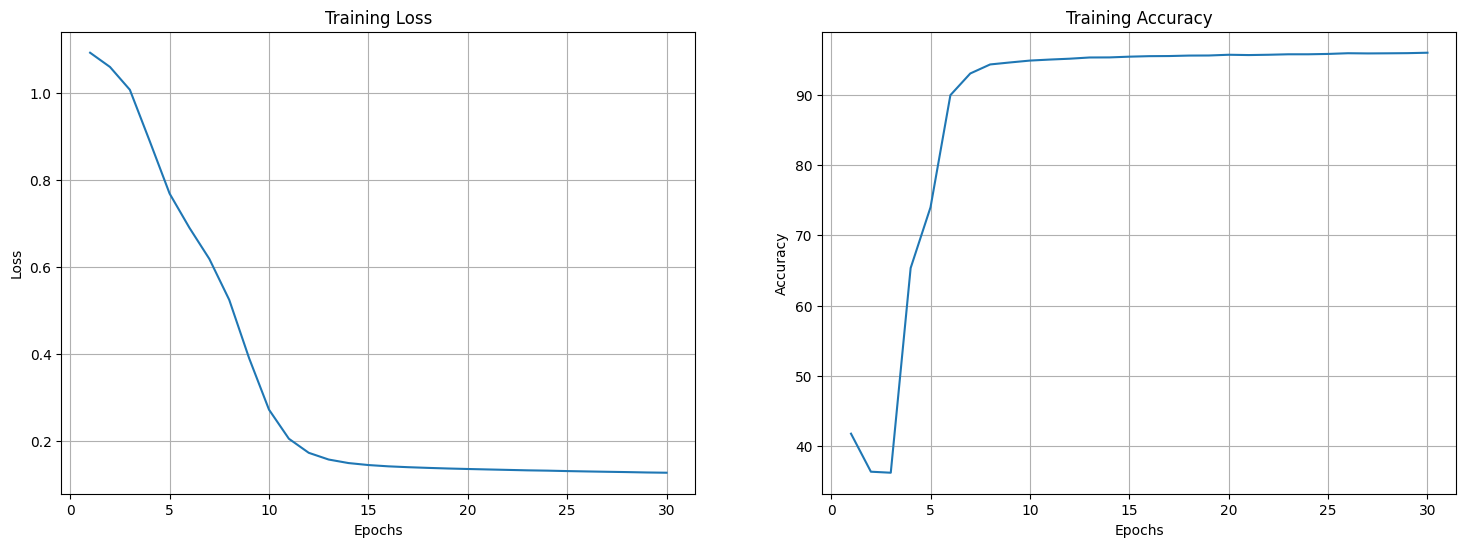

In [18]:
model = nn.Sequential(nn.Conv2d(1, 4, kernel_size=7, stride=3),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Conv2d(4, 4, kernel_size=3, padding=1),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Flatten(),
                      nn.ReLU(),
                      nn.Linear(16, len(kept_classes)))

optimizer = optim.SGD(model.parameters(), lr = 0.001)
results = train_model(model, trainloader, optimizer, n_epochs = 30)
plot_results(*results)

Test accuracy on 3000 test samples is 95.20%


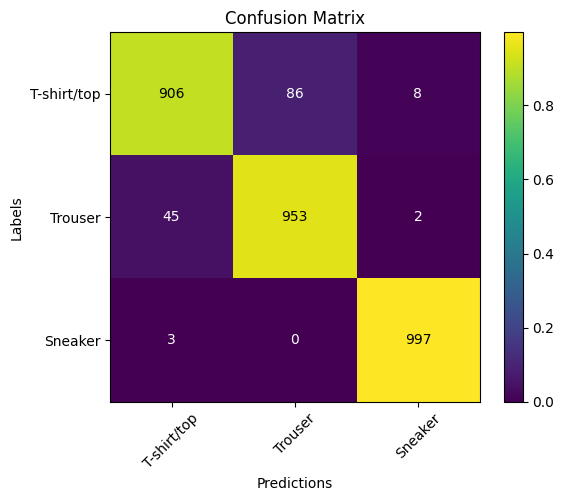

In [20]:
y_test, y_pred = test_model(model, testloader)
class_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
               3: 'Dress', 4: 'Coat', 5:  'Sandal', 6: 'Shirt',
               7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
plot_confusion_matrix(y_test, y_pred, class_names, kept_classes)